In [4]:
!pip install gymnasium[atari,accept-rom-license]
# !pip install gymnasium[pong,accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.3 MB/s eta 0:00:00


In [5]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

env = gym.make("ALE/Pong-v5", render_mode='rgb_array') # 환경 만들기

### Test

In [6]:
obs, info = env.reset()

In [7]:
obs, r, done, _, info = env.step(1)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       [[144,  72,  17],
        [144,  72,  17],
        [144,  72,  17],
        ...,
        [144,  72,  17],
        [144,  72,  17],
        [144,  72,  17]],

       ...,

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[236, 236, 236],
        [236, 236, 236],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]]], dtype=uint8)
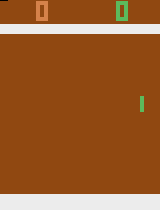

In [8]:
obs

---

## 본 코드

In [9]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torchvision.transforms as T

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 64  # Size of batch taken from replay buffer
max_steps_per_episode = 1000

In [10]:
num_actions = env.action_space.n

class QModel(nn.Module):
    def __init__(self, num_actions):
        super(QModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.dropout = nn.Dropout(p=0.3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        action = self.fc2(x)
        return action

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# The first model makes the predictions for Q-values which are used to
# make a action.
model = QModel(num_actions)
model.to('cuda')

# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = QModel(num_actions)
model_target.to('cuda')

loss_function = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)

In [12]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 100000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 500000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

In [13]:
preprocess = T.Compose([
    T.ToPILImage(),
    T.Grayscale(),
    T.Resize((84, 84)),
    T.ToTensor()
])

# Function to preprocess the state
def preprocess_state(state):
    state = preprocess(state).unsqueeze(0)
    return state

**이미지 포맷:**
1. (N)CHW
2. (N)HWC
  - 주로 이거 !

In [14]:
# Function to select an action
def get_greedy_epsilon(model, state):
    global epsilon

    #if frame_count < epsilon_random_frames or np.random.rand(1)[0] < epsilon:
    if np.random.rand(1)[0] < epsilon:
        action = np.random.randint(num_actions)
    else:
        with torch.no_grad():
            # add a batch axis
            #state = state.unsqueeze(0)
            # compute the q-values
            q_values = model(state)
            # the action of maximum q-value
            action = q_values.argmax().item()

    # decay epsilon
    epsilon -= epsilon_interval / epsilon_greedy_frames
    epsilon = max(epsilon, epsilon_min)

    return action

In [15]:
def get_greedy_action(model, state):
    global epsilon

    with torch.no_grad():
        #state = state.unsqueeze(0) # batch dimension
        q_values = model(state)
        action = q_values.argmax().item()

    return action

In [16]:
# sample a batch of _batch_size from replay buffers
# return numpy.ndarrays
def sample_batch(_batch_size):
    # Get indices of samples for replay buffers
    indices = np.random.choice(range(len(done_history)), size=_batch_size, replace=False)

    state_sample = np.array([state_history[i].squeeze(0).numpy() for i in indices])
    state_next_sample = np.array([state_next_history[i].squeeze(0).numpy() for i in indices])
    rewards_sample = np.array([rewards_history[i] for i in indices], dtype=np.float32)
    action_sample = np.array([action_history[i] for i in indices])
    done_sample = np.array([float(done_history[i]) for i in indices])

    return state_sample, state_next_sample, rewards_sample, action_sample, done_sample

In [17]:
# Function to update the Q-network
def update_network():
    # sample a batch of ...
    state_sample, state_next_sample, rewards_sample, action_sample, done_sample = \
        sample_batch(batch_size)

    # Convert numpy arrays to PyTorch tensors
    state_sample = torch.tensor(state_sample, dtype=torch.float32).to('cuda')
    state_next_sample = torch.tensor(state_next_sample, dtype=torch.float32).to('cuda')
    action_sample = torch.tensor(action_sample, dtype=torch.int64).to('cuda')
    rewards_sample = torch.tensor(rewards_sample, dtype=torch.float32).to('cuda')
    done_sample = torch.tensor(done_sample, dtype=torch.float32).to('cuda')

    # Compute the target Q-values for the states
    with torch.no_grad():
        future_rewards = model_target(state_next_sample)

        # compute the q-value for the next state and the action maximizing the q-value
        max_q_values = future_rewards.max(dim=1).values

        # compute the target q-value
        # if the step was final, max_q_values should not be added
        target_q_values = rewards_sample + gamma * max_q_values * (1. - done_sample)

    # It's forward propagation! Compute the Q-values for the taken actions
    q_values = model(state_sample)
    q_values_action = q_values.gather(dim=1, index=action_sample.unsqueeze(1)).squeeze(1)

    # Compute the loss
    loss = loss_function(q_values_action, target_q_values)

    # Perform the optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [18]:
while True:  # Run until solved
    state, info = env.reset()
    state, reward, done, _, info = env.step(1)
    state = preprocess_state(state)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Select an action
        action = get_greedy_epsilon(model, state.to('cuda'))

        # Take the selected action
        state_next, reward, done, _, info = env.step(action)
        state_next = preprocess_state(state_next)

        episode_reward += reward

        # Store the transition in the replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        rewards_history.append(reward)
        done_history.append(done)

        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            update_network()

        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    episode_count += 1
    episode_reward_history.append(episode_reward)

    # Update running reward to check condition for solving
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    if episode_count % 10 == 0:
        print(f"Episode: {episode_count}, Frame count: {frame_count}, Running reward: {running_reward}")

    if episode_count % 5000 == 0:
        torch.save(model, 'model.{}'.format(episode_count))
    if running_reward > 20:
        print(f"Solved at episode {episode_count}!")
        break
    if episode_count >= 100:
        break


torch.save(model, 'model.final')

Episode: 10, Frame count: 9229, Running reward: -20.2
Episode: 20, Frame count: 18214, Running reward: -20.25
Episode: 30, Frame count: 26436, Running reward: -20.3
Episode: 40, Frame count: 35325, Running reward: -20.05
Episode: 50, Frame count: 43595, Running reward: -20.18
Episode: 60, Frame count: 52245, Running reward: -20.15
Episode: 70, Frame count: 60333, Running reward: -20.257142857142856
Episode: 80, Frame count: 68607, Running reward: -20.3375
Episode: 90, Frame count: 76817, Running reward: -20.377777777777776
Episode: 100, Frame count: 85496, Running reward: -20.41


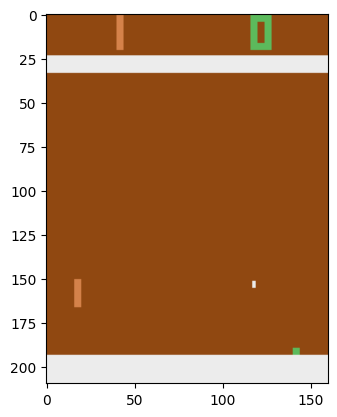

In [19]:
import time, sys
from IPython.display import clear_output
from matplotlib import animation
import matplotlib.pyplot as plt
import glob
import imageio

anim_file = 'pong.gif'

turn =  0
board, info = env.reset()
state = preprocess_state(board)
board, reward, done, _, info = env.step(1)
state = preprocess_state(board)
plt.imshow(board)
plt.savefig('image_at_turn_{:04d}.png'.format(turn))

for timestep in range(1, 100):
    turn += 1
    action = get_greedy_action(model, state.to('cuda'))
    #print(action)
    board, reward, done, _, info = env.step(action)
    state = preprocess_state(board)
    plt.imshow(board)
    plt.savefig('image_at_turn_{:04d}.png'.format(turn))

    if done:
        break

In [20]:
# generate animated gif file
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image_at_turn_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


<ipython-input-20-512146e1f840>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!ls drive/MyDrive/FLY_AI/RL

'P1. atari-breakout-cuda.ipynb'


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!cp atari.gif drive/MyDrive/FLY_AI/RL/atari.gif #